In [4]:
import matplotlib.pyplot as plt
import kalman as kf

from scipy.optimize import fmin, minimize
from importlib import reload
import numpy as np

In [129]:
p_true = [1, 2, 0.1, 0.1, 9.9355, 0.01]
p_init = [2, 1, 0.2, 0.2, 5, 0.05]

In [130]:
x, y = kf.generate_kalman_example(p_true)

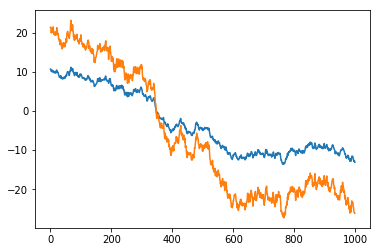

In [131]:
plt.plot(x[1:])
plt.plot(y[1:])
plt.show()

# Optimize

In [134]:
res = fmin(kf.obj(kf.kalman_obj, y), p_init, full_output=True)# kalman

In [135]:
p_opt = res[0]

In [136]:
x_pred = kf.kalman_path(y, p_opt)

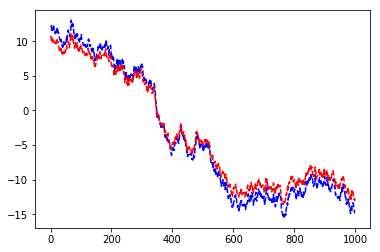

In [137]:
plt.plot(x_pred[1:], 'b--')
plt.plot(x[1:], 'r--')
plt.show()

In [9]:
#toy example
import pandas as pd
#read from data raw data file
SP_data = pd.read_excel(open('C:/Users/wyd15/Desktop/221F_yw/Cubist System/ResearchDatasetV2.0.xlsx','rb'))
SP_data.index = list(SP_data.index)
SP_data.head()

,Date,Signal,ClosePrice
0,20120103,3.107767,127.495
1,20120104,3.107282,127.700
2,20120105,3.099757,128.040
3,20120106,3.134223,127.710
4,20120109,3.135922,128.020


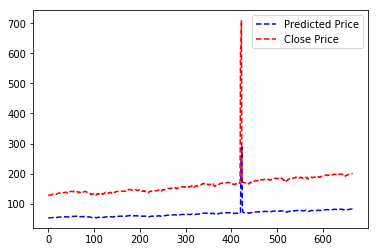

In [10]:
#p_true = [1, 2, 0.1, 0.1, 9.9355, 0.01]
p_init = [2, 1, 0.2, 0.2, 120, 0.1] #what these parameters really means

res = fmin(est.obj(est.kalman_obj, SP_data['ClosePrice'].values), p_init, full_output=True)
p_opt = res[0]
x_pred = est.kalman_path(SP_data['ClosePrice'].values, p_opt, N= len(SP_data)-1)
plt.plot(x_pred[1:], 'b--', label = 'Predicted Price')
plt.plot(SP_data['ClosePrice'][1:].values, 'r--', label= 'Close Price')
plt.legend()
plt.show()

# UKF

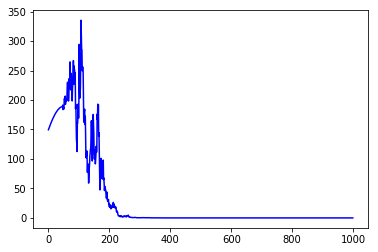

In [7]:
# %A simple simulation of the heston Model, the euler scheme.
# %to avoid negative volatilities a particular truncation is the Heston

def hestsim(params, S0 = 0.5, mu= 0.05, T=30, n=1000, eps=1e-8):
    '''
    function for heston simulation    
    '''
    k = params[0] #kappa
    theta = params[1]
    xi = params[2] #sigma
    rho = params[3]
    V0 = params[4]
    dt = T/n
    
    dw = np.random.randn(2, n)
    S = np.zeros(n)
    V = np.zeros(n)
    Sr = np.zeros(n)
    V[0]=V0
    S[0]=S0
    for s in range(1,n):
        #change abs(V[s-1]) into max(vs,eps)
        V[s] = V[s-1] + k*(theta - max(V[s-1],eps))*dt + xi*np.sqrt(max(V[s-1],eps))*dw[0,s]*np.sqrt(dt)

    for s in range(1,n):
        sr = (mu-0.5*V[s])*dt + np.sqrt(max(V[s-1],eps))*(rho*dw[0,s] + np.sqrt(1-rho**2)*dw[1,s])*np.sqrt(dt)
        S[s] = S[s-1] + sr
        #print(S[s])
        Sr[s]=   sr       
        
    return V, S, Sr

#params = 
V, S, Sr = hestsim(params = [0.2, 2.2, 0.01, 0.29, -0.6, 0.02], S0 = np.log(149.54), mu= 0.0245, T = 30, n=1000)
plt.plot(np.exp(S), 'b-')
plt.show()

In [41]:
#implement ekf
import simulate as sim
import kalman as kf

def ekf(f, params, obs, N):
    '''
    function for ekf update and prediction
    f:      transition function for prediction
    h:      transition function for measurement update
    params: parameter set
    obs:    true observations
    
    '''
    F= params[0]
    U= params[1]
    Q= params[2]
    H= params[3]
    P= params[4]
    v0= params[5]
    x0 =params[6]
    dt = params[7]
    sigma = params[8]
    I = np.eye(2)
    x_pred = np.matrix(np.zeros((2, N+1)))
    x_update = np.matrix(np.zeros((2, N+1)))
    P = np.matrix([[np.sqrt(v0*dt), 0],
                  [0, np.sqrt(v0*dt)]])
    x_update[0,0] = x0
    x_update[1,0] = v0
    obj = 0

    for i in range(1, len(obs)):
        #time update
        x_pred[:, i] = f(x_update[:, i-1])
        P_pred =F*P*F.T+ U*Q*U.T
        A = H*P_pred*H.T
        delta = obs[i] - x_pred[0, i]
        obj+=np.log(abs(A[0, 0])) + delta[0,0]**2/A[0,0]
        
        #measurement update
        K = P*H.T/A
        #print(obs.shape)
        x_update[:,i] = x_pred[:,i] + K*delta
        x_update[1,i] = max(1e-5, x_update[1,i])
        U =  np.matrix([[np.sqrt(x_update[1,i]*dt), 0],
                        [0, sigma*np.sqrt(x_update[1,i]*dt)]])
        P = (I - K*H)*P_pred
    
    return obj


def heston_transition(x):
        mu = 0.6
        kappa= 1.1
        theta= 0.03
        dt = 1/250
        x_next = np.matrix([0,0], dtype=np.float64).T
        x_next[0,0] = x[0,0] + (mu-1/2*x[1,0])*dt
        x_next[1,0] = x[1,0] + kappa*(theta-x[1,0])*dt
        return x_next
    
    
#heston parameter wrapper;
def heston_para(params, dt):
    mu = params[0]
    kappa = params[1]
    theta = params[2]
    sigma = params[3]
    rho = params[4]
    v0 = params[5]
    x0 = params[6]
    
    F = np.matrix([[1, -1/2*dt],
                  [0, 1-kappa*dt]])
    U = np.matrix([[np.sqrt(v0*dt), 0],
                  [0, sigma*np.sqrt(v0*dt)]])
    Q = np.matrix([[1, rho],
                  [rho, 1]])
    H = np.matrix([[1,0]])
    P = np.matrix([[np.sqrt(v0*dt), 0],
                  [0, np.sqrt(v0*dt)]])
    
    
    return [F, U, Q, H, P, v0, x0, dt, sigma]

S0 = 100
init_params = [0.6, 1.1, 0.03, 0.35, -0.4, 0.035]
params = [0.6, 1.1, 0.03, 0.35, -0.4, 0.035, np.log(100)]
N = 1000
obs = sim.simulate_heston_state(init_params, S0, N=1000) 
objs = ekf(heston_transition, heston_para(params, dt=1/250 ), obs[0, :].T, N)
print(objs)

1001
-6961.110617030458


In [12]:
import numpy as np

class ukf():
    
    def __init__(self, params, obs):
        '''
        init function for ukf object
        Args:
        params: alpha, beta, kappa
        obs:    observations, sample points
        Return:
        
        '''
        self.alpha = params[0]
        self.beta = params[1]
        self.kappa = params[2]
        self.obs = obs
        self.n = len(obs)
        
        
    def sigma(self):
        self.sigma = None
        P = []
        c = 
        M = 
        
        A = np.linalg.cholesky(P).T
        X = np.column_stack((np.zeros(len(M)), A))
        X = np.column_stack((X, -A))
        X = np.sqrt(c)*X + np.tile(M,(len(X[1]), 1)).T
    
        return
        
    def weights(self):
        '''
        '''
        alpha = self.alpha
        n = self.n
        kappa = self.kappa
        beta = self.beta
        
        lda = alpha**2 * (n + kappa) - n
        #sigma points
        WM = np.zeros((2*n+1,1))
        WC = np.zeros((2*n+1,1))
        for j in range(0, 2*n+1):
            if j==0:
                wm = lda / (n + lda)
                wc = lda / (n + lda) + (1 - alpha**2 + beta)
            else:
                wm = 1 / (2 * (n + lda))
                wc = wm
            WM[j] = wm
            WC[j] = wc

        c = n + lda
        
        
        return WM, WC
    
    def transform(self):
        '''
        '''
        self.x_pred = None
        return
        
    
    def update(self):
        '''
        '''
        self.x_pred = None
            
        
        return 
    def predict(self):
        '''
        
        '''
        self.y_pred = None
        
        return 
        
        
def test_ukf_weights(params, obs):
    test_ukf = ukf(params, obs)
    M, C = test_ukf.weights()
    
    return M, C

tm, tc = test_ukf_weights([1, 1, 1], [1, 1, 1])

print('test ukf results: measurement weights:', tm, 'coefficient weights: \n', tc)

test ukf results: measurement weights: [[0.25 ]
 [0.125]
 [0.125]
 [0.125]
 [0.125]
 [0.125]
 [0.125]] coefficient weights: 
 [[1.25 ]
 [0.125]
 [0.125]
 [0.125]
 [0.125]
 [0.125]
 [0.125]]


In [ ]:
#ukf implementation

def ukf(f, h,):
    '''
    x_pred:    m*(2m+1)*n
    x_update:  m*(2m+1)*n
    f:         state transformation function 
    h:         measurement transformation function
    
    
    '''
    #initialize
    k = len(obs) #length of the observations
    
    
    #peusodu-code
    for i in range(1, k):
        x_sigmas = ukf_sigma(x[:,:, k-1], gamma, P[:, :, k-1]) #calculate sigma points
    
    #time update
        x_pred[:, :, k-1] = f(x_sigmas)
        weights = ukf_weights(lda, L)
        x_weight = weights * x_pred[:, :, k-1]
        delta_x = x_pred[:, :, k-1]- x_weight
        P_weight = weights*delta_x*delta_x.T + Q
        x_pred[:, :, k-1]=ukf_sigma(x_weight, gamma, P_weight)
        y_pred[:, :, k-1] = h(x_pred[:, :, k-1])
        y_weight = weights * y_pred[:, :, k-1]
        #the defination of A??
        obj +=  np.log(abs(A[0, 0])) + delta[0,0]**2/A[0,0]
    #measurement update
        delta_y = y_pred[:, :, k-1]- y_weight
        P_yy = weights*delta_y*delta_y.T + R
        p_xy = weights*delta_x*delta_y.T
        Kk= P_yy*P_xy
        x_update[:, :, k] = x_weights + Kk*(obs[i]- y_weight)
        P[:, :, k] = P_weight - Kk*P_yy*Kk.T
    
    
    return obj

In [103]:
def ut_weights(n,alpha,beta,kappa):
    '''
    testcase:
    >>>WM,WC,c = ut_weights(6, 1, 1, 1)
    >>>print(c)
    >>>7
    >>>print(WM)
    >>>WM = [[0.14285714][0.07142857] [0.07142857] [0.07142857] [0.07142857] [0.07142857] [0.07142857] 
             [0.07142857] [0.07142857] [0.07142857] [0.07142857] [0.07142857] [0.07142857]]
    '''
    lda = alpha**2 * (n + kappa) - n
    #sigma points
    WM = np.zeros((2*n+1,1))
    WC = np.zeros((2*n+1,1))
    for j in range(0, 2*n+1):
        if j==0:
            wm = lda / (n + lda)
            wc = lda / (n + lda) + (1 - alpha**2 + beta)
        else:
            wm = 1 / (2 * (n + lda))
            wc = wm
        WM[j] = wm
        WC[j] = wc

    c = n + lda
    
    return WM,WC,c


x0=[19, 0.2, 0.25, 0.4, 0.4, 0.4]
P0=0.05*np.eye(len(x0))

M =x0
P =P0
c =1

WM,WC,c = ut_weights(len(M), 1, 1, 1)
print(WC)

[[1.14285714]
 [0.07142857]
 [0.07142857]
 [0.07142857]
 [0.07142857]
 [0.07142857]
 [0.07142857]
 [0.07142857]
 [0.07142857]
 [0.07142857]
 [0.07142857]
 [0.07142857]
 [0.07142857]]


In [101]:
###ukf predict
from inspect import signature

def ut_sigmas(M,P,c):
    A = np.linalg.cholesky(P).T
    #print(A.shape)
    X = np.column_stack((np.zeros(len(M)), A))
    #print(X)
    X = np.column_stack((X, -A))
    #print(X)
    #print((len(X[1]), 1), len(M), np.tile(M,(len(X[1]), 1)).T.shape)
    X = np.sqrt(c)*X + np.tile(M,(len(X[1]), 1)).T
    return X


X= ut_sigmas(M, P, c)
#print(X)

In [126]:
def ut_transform(M,P,g, tr_param, g_param=[]):
    '''
    transition function of ukf
    '''
    alpha= tr_param[0]
    beta = tr_param[1]
    kappa = tr_param[2]
 
    WM,WC,c = ut_weights(len(M),alpha,beta,kappa)
    X = ut_sigmas(M,P,c)
    w = [WM,WC,c]

    if isinstance(g, list):
        Y = np.matmul(g,X)
#     elif str.isalpha(g) or callable(g): #lambda
#         Y = []
#         for i in range(1,X.shape()[1]):
#                 Y = [Y , feval(g,X[:,i],g_param)]
#     else:
#         Y = []
#         for i in range(1, X.shape()[1]):
#                 Y = [Y, g(X[:,i],g_param)]
    #print(Y.shape[1])
    mu = np.zeros((len(Y[0]),1))
    S  = np.zeros((len(Y[0]), len(Y[0])))
    C  = np.zeros((len(Y[0]),len(Y[0])))
    for i in range(1, len(X[0])):
        mu = mu + WM[i] * Y[:, i]
        
    for i in range(1, len(X[0])):
        #print(np.matmul((Y[:, i] - mu),(Y[:, i] - mu).T) )
        #print((X[0:len(M),i] - M))
        #print(mu)
        #print((X[0:len(M),i] - M))
        S = S + WC[i] *  np.matmul((Y[:, i] - mu),(Y[:, i] - mu).T)  #(Y[:, i] - mu)*(Y[:, i] - mu).T 
        
        C = C + WC[i] * np.matmul((X[0:len(M),i] - M) ,(Y[:, i] - mu).T) #(X[0:len(M),i] - M) * (Y[:] - mu).T
        
    return mu,S,C,X,Y,w

param = [1, 1, 1, 0]
f=[1] #[[1, 1, 1, 0, 0, 90], [1, 1, 1, 0, 0, 90]]
M = x0
mu,S,C,X,Y,w=ut_transform(M,P,f, tr_param= param)

ValueError: shapes (1,) and (6,13) not aligned: 1 (dim 0) != 6 (dim 0)

In [120]:
def ukf_predict1(M,P,f,Q,f_param = [],alpha=[],beta=[],kappa=[],mat=0):
#     sig = signature(ukf_predict1)
#     nargin = len(sig.parameters)
    
#     if nargin< 2: 
#         raise('Too few arguments')
#     if nargin < 3:
#         f = []
#     if nargin < 4:
#         Q = []
#     if nargin < 5:
#         f_param = []
#     if nargin < 6:
#         alpha = []
#     if nargin < 7:
#         beta = []
#     if nargin < 8:
#         kappa = []
#     if nargin < 9:
#         mat = []

    if len(f) ==0 :
        f = np.eye(len(M))

    if len(Q)==0:
        Q = np.zeros(len(M))

    if len(mat)==0:
        mat = 0
  
    tr_param = [alpha,beta,kappa,mat]
    M,P,D,_,_,_ = ut_transform(M,P,f,f_param,tr_param)
    
    P = P + Q

    return M, P, D

In [121]:
def  gauss_pdf(X,M,S):
    '''
    implementation of gaussion distribution
    
    '''
    if len(M[1]) == 1:
        DX = X-np.tile(M,(len(X[1]), 1)).T  
        E = 0.5*sum(np.matmul(DX, (np.linalg.lstsq(S,Dx)[0])))
        d = len(M)
        E = E + 0.5 * d * log(2*pi) + 0.5 * log(det(S))
        P = np.exp(-E)
    elif len(X[1]) == 1:
        DX = np.tile(X,(1,len(M[1])))-M 
        E = 0.5*sum(np.matmul(DX, (np.linalg.lstsq(S,Dx)[0])))
        d = len(M)
        E = E + 0.5 * d * log(2*pi) + 0.5 * log(det(S))
        P = np.exp(-E)
    else:
        DX = X-M
        E = 0.5*np.matmul(DX, (np.linalg.lstsq(S,Dx)[0]))
        E = E + 0.5 * d * log(2*pi) + 0.5 * log(det(S))
        P = np.exp(-E)
    
    return P, E

In [122]:
def ukf_update1(M,P,Y,h,R,h_param,alpha,beta,kappa,mat):
#     sig = signature(ukf_update1)
#     nargin = len(sig.parameters)
    
#     if nargin < 5:
#         raise('Too few arguments')
#     if nargin < 6:
#         h_param = []
#     if nargin < 7:
#         alpha = []

#     if nargin < 8:
#         beta = []

#     if nargin < 9:
#         kappa = []

#     if nargin < 10:
#         mat = []
#     if len(mat):
#         mat = 0
    
    tr_param = [alpha, beta, kappa, mat]
    MU,S,C,_,_,_ = ut_transform(M,P,h,h_param,tr_param)
  
    S = S + R
    K = C / S
    M = M + K * (Y - MU)
    P = P - K * S * K.T
  
    #if nargout > 5: #likelihood function
    LH = gauss_pdf(Y,MU,S)
        
    return M,P,K,MU,S,LH

In [123]:
### matlab script for simulation

S0 = 20 
V0 = .1 
mu= 0.05 
ki =0.5
theta =2 
xi= .5 
dt = 1/252 
rho =0.7
#%% Filters tools
n = 2000
dim=6
dw1=np.random.randn(1,n)
dw2=np.random.randn(1,n)
dw3=np.random.randn(1,n)
dw=[rho*dw2+np.sqrt(1-rho**2)*dw1, dw2]
#%--------------------------
V,S,S2=hestsim(S0,V0,mu,ki,theta,xi,dt,rho,n)
Data=pd.read_excel(open('C:/Users/wyd15/Desktop/CMinF/Filtering_code_Ali/Chapter8/dexiahistorical.xls','rb'))
Data2=pd.read_excel(open('C:/Users/wyd15/Desktop/CMinF/Filtering_code_Ali/Chapter8/dexia2.xls','rb'))
#%-----------------------------
x0=[19, 0.2, 0.25, 0.4, 0.4, 0.4]
e=0.5*np.ones((1,dim))
P0=0.05*np.eye(dim)


#%-----------------------------------------
x=np.zeros((dim,n)) 
x2=np.zeros((dim,n))
x[:,1]=x0
x2[:,1]=x0
Pm=np.zeros((dim,dim,n))
Pp=np.zeros((dim,dim,n))
Pp[:,:,1]=P0
xm=x0
vi=np.zeros((1,n,6))


# %----------------------------
# %The state-space-model
# %----------------
def f(x,k):
    mu=0.05
    dt=1/252
    rho =-0.5
    dw1=np.random.randn();
    dw2=np.random.randn();
    dw3=np.random.randn();
    dw=[rho*dw2+np.sqrt(1-rho**2)*dw1, dw2]


    xm=[x[0]+(mu-0.5*abs(x[1]))*dt+np.sqrt(abs(x[1])*dt)*dw[0], 
       x[1]+(x[2]-x[3]*abs(x[1]))*dt+x[4]*np.sqrt(abs(x[1])*dt)*dw[1],
        x[2], 
        x[3], 
        x[4], 
        x[5]]
    return xm

def Q(x,k):
    dim=6
    e=0.0005*np.ones((1,dim))
    dt=1/252
    Q=[[e[0]*((np.sqrt(abs(x[1])*dt)))^2 ,x[5], 0, 0, 0, 0],
           [x[5],e[1]*x[4]*(np.sqrt(dt*abs(x[1])))**2, 0, 0, 0, 0],
               [0, 0, e[2], 0, 0, 0],
               [0, 0, 0, e[3], 0, 0],
               [0, 0, 0, 0, e[4], 0],
               [0, 0, 0, 0, 0, e[5]]]
    return Q
   

def Q2(x,k):
    dim=6
    e=0.5*np.ones((dim, 1))
    dt=1/252
    Q=[[float((e[0]*((np.sqrt(abs(x[1])*dt))))**2), float(e[0]*((np.sqrt(abs(x[1])*dt)))*e[1]*x[4]*(np.sqrt(dt*abs(x[1]))*x[5])),0 ,0,0,0 ],
        [float(e[0]*((np.sqrt(abs(x[1]*dt)))*e[1]*x[4]*(np.sqrt(dt*abs(x[1]))))*x[5]),float((e[1]*x[4]*(np.sqrt(dt*abs(x[1]))))**2),0,0,0,0],
               [0, 0 ,0 ,0, 0, 0],
               [0 ,0 ,0 ,0 ,0 ,0],
               [0, 0 ,0 ,0, 0, 0], 
               [0, 0, 0, 0, 0, 0]]
    return Q

def R(x,k):
    R=0.0005
    return R

def h(x,k):
    h=x(1)
    return h

def A(x):

    dt=1/252
    dim=6
    
    Aa=[[1,-0.5*dt, 0,0 ,0,0], 
        [0,1-x[3]*dt ,dt ,-x[1]*dt, 0,0],
        [0 ,0 ,1, 0 ,0 , 0],
        [0,0 ,0 ,1, 0,0],
        [0 ,0, 0,0 ,1 ,0],
        [0, 0, 0, 0,0,1]]
    
    return Aa

def H(x,k):
    dt=1/252
    Hd=[1,0, 0, 0, 0, 0]
    return Hd


In [130]:
# UKF  Algorithme
# % ---------------------------------------------------------
M = x0
P = P0
MM_UKF1 = np.zeros((len(M),n))
PP_UKF1 = np.zeros((len(M),len(M),n))
# %Filtering loop for UKF1
# %-----------------------


for k in range(2, n):
    Q1=Q2(x[:,k-1],k)
    A1=A(x[:,k-1])
    f1=f(x[:,k-1],k)
    H1=H(x[:,k-1],k)
    M,P,_ = ukf_predict1(M,P,A1,Q1,f_param = [],alpha=1,beta=1,kappa=1,mat=[])
    M,P,_,_,_ = ukf_update1(M,P,np.log(Data2.iloc[k,2]),H1,0.005, h_param = [],alpha=1,beta=1,kappa=1,mat=[])
    
    x2[:,k]   = M
    PP_UKF1[:,:,k] = P    
 


1
1


IndexError: too many indices for array